[0]	validation_0-rmse:44.22152	validation_1-rmse:33.54510
[100]	validation_0-rmse:24.88565	validation_1-rmse:23.88878
[200]	validation_0-rmse:17.77751	validation_1-rmse:21.96253
[300]	validation_0-rmse:14.46331	validation_1-rmse:21.30738
[400]	validation_0-rmse:12.71147	validation_1-rmse:20.97536
[500]	validation_0-rmse:11.53472	validation_1-rmse:20.84213
[600]	validation_0-rmse:10.58940	validation_1-rmse:20.75369
[633]	validation_0-rmse:10.31142	validation_1-rmse:20.75363
R^2: 0.4393
MAE: 15.00 gCO2/kWh


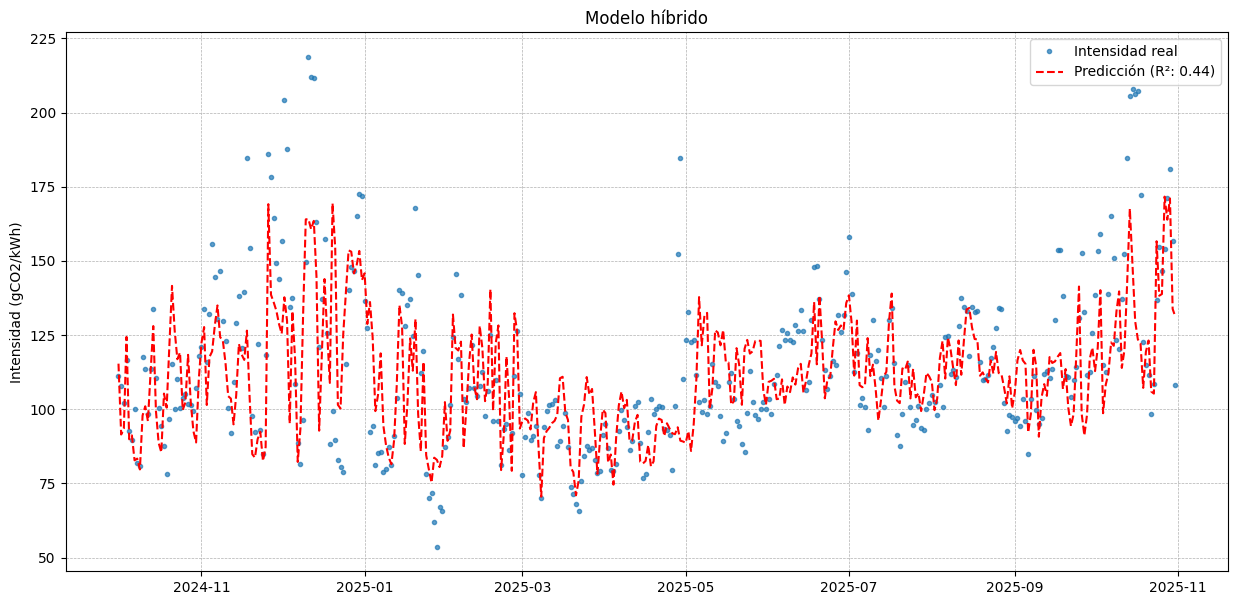

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import os
import sys

DATA_PATH = '../data/2_processed/dataset_maestro_5min.parquet'
df_5min = pd.read_parquet(DATA_PATH)
df_5min = df_5min.sort_index()

emisiones_5min = (
    (df_5min['cc'] * df_5min['factorEmisionCO2_cc']) +
    (df_5min['car'] * df_5min['factorEmisionCO2_car']) +
    (df_5min['cogenResto'] * df_5min['factorEmisionCO2_cogenResto']) +
    (df_5min['die'] * df_5min['factorEmisionCO2_die']) +
    (df_5min['gas'] * df_5min['factorEmisionCO2_gas']) +
    (df_5min['vap'] * df_5min['factorEmisionCO2_vap'])
)

df_5min['intensidad_g_kWh'] = (emisiones_5min / df_5min['dem']) * 1000
df_5min['sol_total'] = df_5min['solFot'] + df_5min['solTer']

agg_dict = {
    'intensidad_g_kWh': 'mean',
    'eol': 'sum',
    'sol_total': 'sum',
    
    'temp_max_nacional_ponderada': 'first',
    'temp_min_nacional_ponderada': 'first',
    'viento_nacional_ponderado': 'first',
    'precipitacion_nacional_ponderada': 'first',
    'dia_año_sin': 'first', 'dia_año_cos': 'first',
    'dia_semana_sin': 'first', 'dia_semana_cos': 'first',
}
df_1d = df_5min.resample('D').agg(agg_dict)
df_1d = df_1d.rename(columns={
    'intensidad_g_kWh': 'intensidad_co2',
    'eol': 'eol_total_dia',
    'sol_total': 'sol_total_dia'
})

MODEL_DIR = '../models'
try:
    model_eol = xgb.XGBRegressor()
    model_eol.load_model(os.path.join(MODEL_DIR, 'modelo_eol.json'))
    
    model_sol = xgb.XGBRegressor()
    model_sol.load_model(os.path.join(MODEL_DIR, 'modelo_sol.json'))
except Exception as e:
    print(f"No se pudieron cargar los modelos eol/sol. {e}")
    sys.exit()

H = 7
W = 28
df_1d['co2_lag_7d'] = df_1d['intensidad_co2'].shift(H) 
df_1d['co2_lag_14d'] = df_1d['intensidad_co2'].shift(H * 2)
df_1d['co2_mean_28d'] = df_1d['intensidad_co2'].shift(H).rolling(window=W).mean()
df_1d['co2_std_28d'] = df_1d['intensidad_co2'].shift(H).rolling(window=W).std()

df_1d['eol_total_lag_7d'] = df_1d['eol_total_dia'].shift(H)
df_1d['eol_total_lag_14d'] = df_1d['eol_total_dia'].shift(H * 2)
df_1d['eol_total_mean_28d'] = df_1d['eol_total_dia'].shift(H).rolling(window=W).mean()

df_1d['sol_total_lag_7d'] = df_1d['sol_total_dia'].shift(H)
df_1d['sol_total_lag_14d'] = df_1d['sol_total_dia'].shift(H * 2)
df_1d['sol_total_mean_28d'] = df_1d['sol_total_dia'].shift(H).rolling(window=W).mean()
df_1d['sol_total_std_28d'] = df_1d['sol_total_dia'].shift(H).rolling(window=W).std()
df_1d['sol_total_lag_364d'] = df_1d['sol_total_dia'].shift(364)

df_1d = df_1d.dropna()

FEATURES_EOL = ['viento_nacional_ponderado', 'dia_año_sin', 'dia_año_cos', 'eol_total_lag_7d', 'eol_total_lag_14d', 'eol_total_mean_28d']
FEATURES_SOL = ['dia_año_sin', 'dia_año_cos', 'precipitacion_nacional_ponderada', 'sol_total_lag_7d', 'sol_total_lag_14d', 'sol_total_mean_28d', 'sol_total_std_28d', 'sol_total_lag_364d']

df_1d['pred_eol_h7'] = model_eol.predict(df_1d[FEATURES_EOL])
df_1d['pred_sol_h7'] = model_sol.predict(df_1d[FEATURES_SOL])

TARGET = 'intensidad_co2'
FEATURES = [
    'temp_max_nacional_ponderada',
    'temp_min_nacional_ponderada',
    'dia_año_sin', 'dia_año_cos',
    'dia_semana_sin', 'dia_semana_cos',
    'co2_lag_7d', 'co2_lag_14d', 'co2_mean_28d', 'co2_std_28d',
    'pred_eol_h7',
    'pred_sol_h7'
]

X = df_1d[FEATURES]
y = df_1d[TARGET]

TEST_START_DATE_DIARIO = '2024-10-01'
X_train = X.loc[X.index < TEST_START_DATE_DIARIO]
y_train = y.loc[y.index < TEST_START_DATE_DIARIO]
X_test = X.loc[X.index >= TEST_START_DATE_DIARIO]
y_test = y.loc[y.index >= TEST_START_DATE_DIARIO]

model_hibrido = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5, 
    objective='reg:squarederror', 
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model_hibrido.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  verbose=100)

preds = model_hibrido.predict(X_test)
r2_final = r2_score(y_test, preds)
mae_final = mean_absolute_error(y_test, preds)

print(f"R^2: {r2_final:.4f}")
print(f"MAE: {mae_final:.2f} gCO2/kWh")

plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Intensidad real', 
         marker='.', linestyle='None', alpha=0.7)
plt.plot(y_test.index, preds, 
         label=f'Predicción (R²: {r2_final:.2f})', 
         linestyle='--', color='red')
plt.title('Modelo híbrido')
plt.ylabel('Intensidad (gCO2/kWh)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()